In [1]:
import sys
sys.path.append('/home/silke/Python/radarlecture2016/radarmeteorology/common')
import warnings
warnings.filterwarnings('ignore')
from helper import create_filename
import pandas as pd 
import numpy as np
import datetime as dt
import glob
from scipy import stats
import wradlib as wrl
from scipy import ndimage
import math
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib import colors
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import os
import glob
import scipy
from pandas import rolling_median
import pandas as pd
from scipy.stats import linregress
import numpy.ma as ma
from numpy import asarray as ar
import datetime as dt
from datetime import timedelta
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator,DateFormatter, drange
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import matplotlib

In [2]:
#%pylab

In [3]:
def get_miub_cmap():
    startcolor = 'white'  # a dark olive
    color1 = '#8ec7ff'#'cyan'    # a bright yellow
    color2 = 'dodgerblue'
    color3 = 'darkgreen'
    #color3 = 'lime'
    color4 = 'yellow'
    color5 = 'darkorange'
    color6 = 'red'
    #color7 = 'purple'
    endcolor = 'darkmagenta'    # medium dark red
    colors = [startcolor, color1, color2, color3, color4, color5, color6, endcolor]
    return mpl.colors.LinearSegmentedColormap.from_list('miub1',colors)


In [4]:
def add_cbar(im, ticks, norm):
    cbar = pl.colorbar(im[-1], norm=norm, boundaries=ticks, pad=0.05)
    cbar.locator = mpl.ticker.FixedLocator(ticks)
    cbar.update_ticks()
    return cbar

In [5]:
def get_norm(ticks):
    cmap = get_miub_cmap()
    norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
    return norm

In [6]:
def shift(xs, n):
    if n >= 0:
        return np.r_[np.full(n, np.nan), xs[:-n]]
    else:
        return np.r_[xs[-n:], np.full(-n, np.nan)]

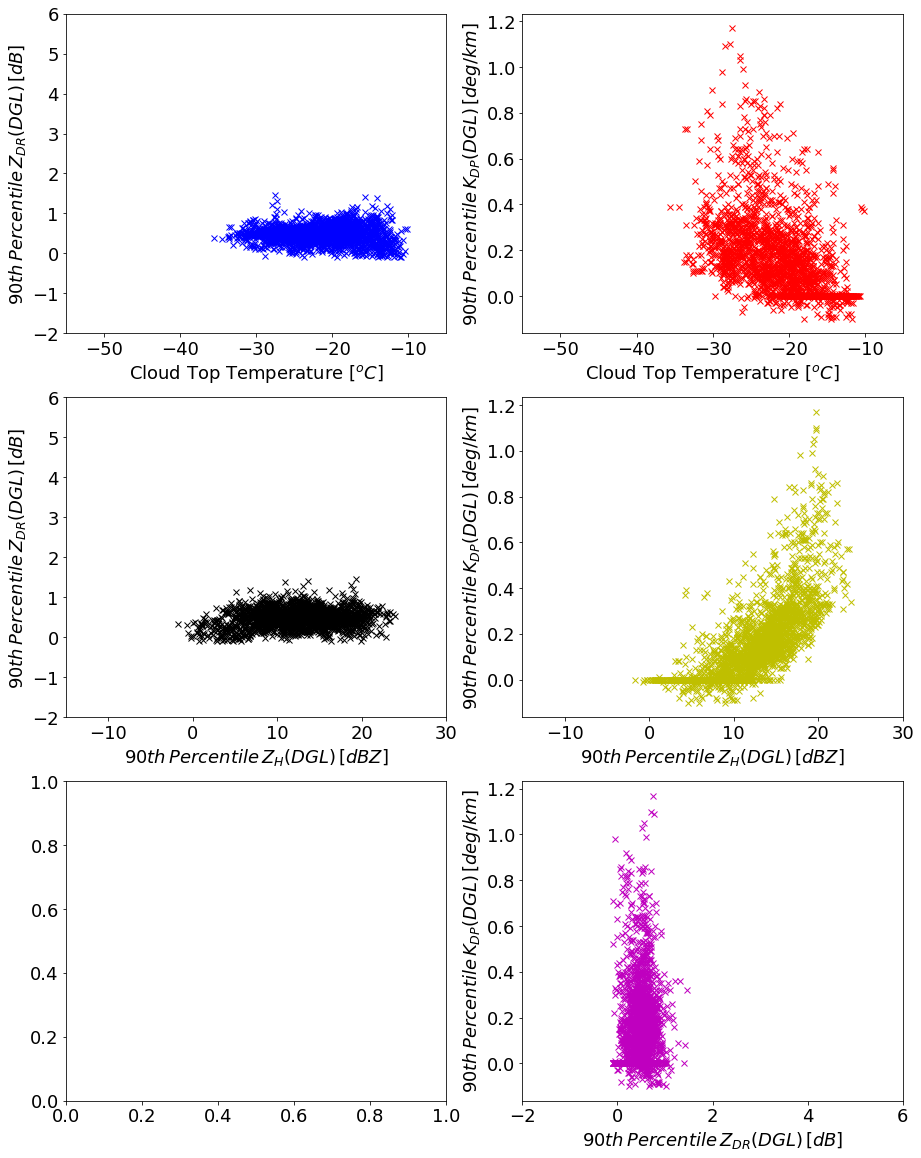

In [7]:
datepath="/home/silke/Python/projects/climatology/"
outputf = sorted(glob.glob(datepath + "Erika*.txt"))
dates=range(len(outputf))
Kdp_DGL_clim=[]
Zdr_DGL_clim=[]
Zh_DGL_clim=[]
Ctt_clim=[]

for l in range(len(outputf)):
    #print(outputf[7:15])
    in_file= open(outputf[l],"r")
    data =np.loadtxt(in_file, skiprows=1, usecols=range(1,5,1), dtype = 'f4')
    in_file.close()
    #Uhrzeit in 5min Schritten
    #Time=[]
    #90-Perzentil von KDP in DGL 
    Kdp_DGL=[]
    #90-Perzentil von Zdr in DGL 
    Zdr_DGL=[]
    #90-Perzentil von Zh in DGL 
    Zh_DGL=[]
    #Cloud top temperature (defined where Zh drops below -10 dBZ) 
    Ctt=[]
    ##
    Kdp_DGL=data[:,0]
    Kdp_DGL_clim.extend(Kdp_DGL)
    Zdr_DGL=data[:,1]
    Zdr_DGL_clim.extend(Zdr_DGL)
    Zh_DGL=data[:,2]
    Zh_DGL_clim.extend(Zh_DGL)
    Ctt=data[:,3]
    Ctt_clim.extend(Ctt)

Kdp_DGL_clim=np.stack(Kdp_DGL_clim)
Zdr_DGL_clim=np.stack(Zdr_DGL_clim)
Zh_DGL_clim=np.stack(Zh_DGL_clim)
Ctt_clim=np.stack(Ctt_clim)
#missing= np.isnan(Zh_DGL_clim) | np.isnan(Kdp_DGL_clim)| np.isnan(Zdr_DGL_clim)| np.isnan(Ctt_clim)|(Zdr_DGL_clim<-0.1)|(Ctt_clim>-10)|(Kdp_DGL_clim<-0.1)
missing= (Ctt_clim>-10)|(Kdp_DGL_clim<-0.1)|(Zdr_DGL_clim<-0.1)
Kdp_DGL_clim=Kdp_DGL_clim[~missing]
Zdr_DGL_clim=Zdr_DGL_clim[~missing]
Zh_DGL_clim=Zh_DGL_clim[~missing]
Ctt_clim=Ctt_clim[~missing]

matplotlib.rcParams.update({'font.size': 18})
fig, ax = pl.subplots(3,2, figsize=(15, 20))
ax[0,0].plot(Ctt_clim, Zdr_DGL_clim, 'bx')
ax[0,0].set_xlabel(r"Cloud Top Temperature [$^oC$]")
ax[0,0].set_ylabel(r"$90th\, Percentile\, Z_{DR}(DGL)\, [dB]$")
ax[0,0].set_xlim([-55,-5])
ax[0,0].set_ylim([-2,6])
ax[0,1].plot(Ctt_clim, Kdp_DGL_clim, 'rx')
ax[0,1].set_xlabel(r"Cloud Top Temperature [$^oC$]")
ax[0,1].set_ylabel(r"$90th\, Percentile\, K_{DP}(DGL)\, [deg/km]$")
ax[0,1].set_xlim([-55,-5])
ax[1,0].plot(Zh_DGL_clim, Zdr_DGL_clim, 'kx')
ax[1,0].set_xlabel(r"$90th\, Percentile\, Z_{H}(DGL)\, [dBZ]$")
ax[1,0].set_ylabel(r"$90th\, Percentile\, Z_{DR}(DGL)\, [dB]$")
ax[1,0].set_xlim([-15,30])
ax[1,0].set_ylim([-2,6])
ax[1,1].plot(Zh_DGL_clim, Kdp_DGL_clim, 'yx')
ax[1,1].set_xlabel(r"$90th\, Percentile\, Z_{H}(DGL)\, [dBZ]$")
ax[1,1].set_ylabel(r"$90th\, Percentile\, K_{DP}(DGL)\, [deg/km]$")
ax[1,1].set_xlim([-15,30])
ax[2,1].plot(Zdr_DGL_clim, Kdp_DGL_clim, 'mx')
ax[2,1].set_xlabel(r"$90th\, Percentile\, Z_{DR}(DGL)\, [dB]$")
ax[2,1].set_ylabel(r"$90th\, Percentile\, K_{DP}(DGL)\, [deg/km]$")
ax[2,1].set_xlim([-2,6])
pl.show()
fig.savefig('/home/silke/Python/projects/climatology/DGL-relations-ErikaGriffin.png')